In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [ ]:
def process_csv(file_name):
  data_path = os.path.join('/content/drive/MyDrive', file_name)
  my_data = pd.read_csv(data_path)
  x = my_data.iloc[:,0]
  x = x.tolist()
  y = my_data.iloc[:,1]
  y  = y.tolist()
  for i in range(len(x)):
      x[i] = x[i].replace("],",",").replace(" [","").replace(" ","").replace("[[","").replace("]]","").split(',')
      x[i] = np.array([float(num) for num in x[i]])
  ts_x = np.array(x)
  ts_y = np.array(y)
  return ts_x, ts_y

def save_csv(dataset, labels, file_name):
  #Saves dataframe
  df = pd.DataFrame({'Features': dataset, 'Label': labels})
  file_path = os.path.join('/content/drive/MyDrive', file_name)
  df.to_csv(file_path, index=False)

In [ ]:
def append_correctly(x, y, arr, img, slope_more, side):
    if x==side: x=x-1
    if y==side: y=y-1
    if x<0: x=0
    if y<0: y=0
    if slope_more: arr.append(list(img[x,y]))
    else: arr.append(list(img[y,x]))

def get_pixels(img, radius, vis, side):
    xc, yc = radius, radius #Center coordinates
    pixel_arr = []
    ang = 0
    spokes = 12
    end = 180-180/spokes
    jump = 180/spokes
    while ang<=end:
        pixel_ang = get_pixels_at_angle(xc, yc, ang, radius, img, vis, side)
        pixel_arr.append(pixel_ang)
        ang+=jump
    return pixel_arr

In [ ]:
def get_pixels_at_angle(xc, yc, ang, radius, img, vis, side):
    ang_rad = math.radians(ang)
    xd, yd = (int)(math.cos(ang_rad)*radius), (int)(math.sin(ang_rad)*radius)
    x1, y1 = xc-xd, yc+yd
    x, y = x1, y1 #Starting coordinates
    x2, y2 = xc+xd, yc-yd #End coordinates
    dx, dy = abs(x2-x1), abs(y2-y1)
    pixels = []
    slope_more = False

    if dx!=0:
        gradient = dy/float(dx)
        if gradient>1:
            dx, dy = dy, dx
            x, y = y, x
            x1, y1 = y1, x1
            x2, y2 = y2, x2
            slope_more = True
    else:
        #Handling 90 degree case
        for k in range(y2,y1):
            vis[(x,k)]=True
            pixels.append(list(img[k,x]))
        return pixels

    if slope_more:
        vis[(y,x)]=True
        append_correctly(x, y, pixels, img, slope_more, side)
    else:
        vis[(x,y)]=True
        append_correctly(x, y, pixels, img, slope_more, side)

    d=2*dy-dx
    for k in range(0,dx-1):
        if d>0:
            y=y+1 if y<y2 else y-1
            d=d+2*(dy-dx)
        else:
            d=d+2*dy
        x=x+1 if x<x2 else x-1

        if slope_more:
            vis[(y,x)]=True
            append_correctly(x, y, pixels, img, slope_more, side)
        else:
            vis[(x,y)]=True
            append_correctly(x, y, pixels, img, slope_more, side)
    return pixels

In [ ]:
#Import data from library
from keras.datasets import cifar10
(trainx, trainy), (testx, testy) = cifar10.load_data()

In [ ]:
#Normalize values between range 0-1
train_x = trainx.astype('float32')/255.0
test_x = testx.astype('float32')/255.0

#Convert y into correct shape
train_y = np.empty(trainy.shape[0],dtype=int)
test_y = np.empty(testy.shape[0],dtype=int)
for i in range(trainy.shape[0]):
    train_y[i] = trainy[i][0].astype(int)
for i in range(testy.shape[0]):
    test_y[i] = testy[i][0].astype(int)

In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
datagen = ImageDataGenerator(
        height_shift_range=0.10,
        rotation_range=15.0,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def get_aug1d(x,y):
  dataset = []
  labels = []
  for (image,yi) in zip(x,y):
    aug_arr = []
    img2 = image
    pix = img_to_array(img2)
    pix = pix.reshape((1,) + pix.shape)
    extra = 2
    start = 1
    for batch in datagen.flow(pix, batch_size=1):
        aug_arr.append(batch[0])
        start += 1
        if start>extra:
            break

    for aug_img in aug_arr:
        sd = aug_img.shape[0]
        rad = sd//2
        vis2 = {}
        pixe = get_pixels(aug_img,rad,vis2,sd)
        tem = []
        for i in range(0,len(pixe)):
            if i%2==0:
                for j in range(0,len(pixe[i])):
                    tem.append(pixe[i][j])
            else:
                for j in range(len(pixe[i])-1,-1,-1):
                    tem.append(pixe[i][j])
        dataset.append(tem)
        labels.append(yi)
  return dataset,labels

In [ ]:
def get_1d(x,y):
  dataset = []
  labels = []
  for (image,yi) in zip(x,y):
    side = image.shape[0]
    radius = side//2
    vis = {}
    pixel_array = get_pixels(image, radius, vis, side)
    temp = []
    for i in range(0,len(pixel_array)):
        if i%2==0:
            for j in range(0,len(pixel_array[i])):
                temp.append(pixel_array[i][j])
        else:
            for j in range(len(pixel_array[i])-1,-1,-1):
                temp.append(pixel_array[i][j])
    dataset.append(temp)
    labels.append(yi)
  return dataset,labels

In [ ]:
trainx_aug, trainy_aug = get_aug1d(train_x,train_y)
trainx_normal, trainy_normal = get_1d(train_x,train_y)
testx_normal, testy_normal = get_1d(test_x,test_y)

In [ ]:
save_csv(trainx_aug, trainy_aug, 'cifar_aug.csv')
save_csv(testx_normal, testy_normal, 'cifar_test.csv')
save_csv(trainx_normal, trainy_normal, 'cifar.csv')

In [ ]:
#Merge augmented and normal training dataframes
p1 = '/content/drive/MyDrive/cifar.csv'
p2 = '/content/drive/MyDrive/cifar_aug.csv'
d1 = pd.read_csv(p1)
d2 = pd.read_csv(p2)
x_train_merged = pd.concat([d1, d2])
len(x_train_merged)

150000

In [ ]:
file_name = 'cifar_train.csv'
file_path = os.path.join('/content/drive/MyDrive', file_name)
x_train_merged.to_csv(file_path, index=False)

In [ ]:
x_final_train, y_train_final = process_csv('cifar_train.csv')
x_final_test, y_test_final = process_csv('cifar_test.csv')

In [ ]:
#One-hot encoding
num = 10
y_final_train = []
for i in range(len(y_train_final)):
    lst = np.zeros(num).astype(int)
    lst[y_train_final[i]] = 1
    y_final_train.append(lst)
y_final_test = []
for i in range(len(y_test_final)):
    lst = np.zeros(num).astype(int)
    lst[y_test_final[i]] = 1
    y_final_test.append(lst)
y_final_train = np.array(y_final_train)
y_final_test = np.array(y_final_test)

In [ ]:
print(x_final_train.shape)
print(y_final_train.shape)
print(x_final_test.shape)
print(y_final_test.shape)

(150000, 996)
(150000, 10)
(10000, 996)
(10000, 10)


In [ ]:
model = Sequential([
    Input(shape=(x_final_train.shape[1],1)),

    #1st Convolutional block
    Conv1D(filters=32,kernel_size=3,activation='relu'),
    Conv1D(filters=32,kernel_size=3,activation='relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=2),

    #2nd Convolutional block
    Conv1D(filters=64,kernel_size=3,activation='relu'),
    Conv1D(filters=64,kernel_size=3,activation='relu'),
    Dropout(0.2),
    MaxPooling1D(pool_size=2),

    #3rd Convolutional block
    Conv1D(filters=128,kernel_size=3,activation='relu'),
    Conv1D(filters=128,kernel_size=3,activation='relu'),
    Dropout(0.3),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(1024,activation='relu'),
    Dropout(0.4),
    Dense(256,activation='relu'),
    Dropout(0.3),
    Dense(10,activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 994, 32)           128       
                                                                 
 conv1d_13 (Conv1D)          (None, 992, 32)           3104      
                                                                 
 dropout_10 (Dropout)        (None, 992, 32)           0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 496, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 494, 64)           6208      
                                                                 
 conv1d_15 (Conv1D)          (None, 492, 64)           12352     
                                                      

In [ ]:
history = model.fit(x_final_train, y_final_train, validation_data = (x_final_test,y_final_test), epochs = 15, batch_size = 128)

Epoch 1/15
1172/1172 [==============================] - 42s 32ms/step - loss: 1.5007 - accuracy: 0.4582 - val_loss: 1.1818 - val_accuracy: 0.5854
Epoch 2/15
1172/1172 [==============================] - 36s 31ms/step - loss: 1.1623 - accuracy: 0.5870 - val_loss: 1.0592 - val_accuracy: 0.6228
Epoch 3/15
1172/1172 [==============================] - 37s 32ms/step - loss: 1.0167 - accuracy: 0.6393 - val_loss: 0.9977 - val_accuracy: 0.6480
Epoch 4/15
1172/1172 [==============================] - 37s 31ms/step - loss: 0.9023 - accuracy: 0.6810 - val_loss: 0.9506 - val_accuracy: 0.6669
Epoch 5/15
1172/1172 [==============================] - 36s 31ms/step - loss: 0.8092 - accuracy: 0.7122 - val_loss: 0.9239 - val_accuracy: 0.6743
Epoch 6/15
1172/1172 [==============================] - 36s 31ms/step - loss: 0.7249 - accuracy: 0.7427 - val_loss: 0.9357 - val_accuracy: 0.6736
Epoch 7/15
1172/1172 [==============================] - 37s 31ms/step - loss: 0.6603 - accuracy: 0.7656 - val_loss: 0.9167 -

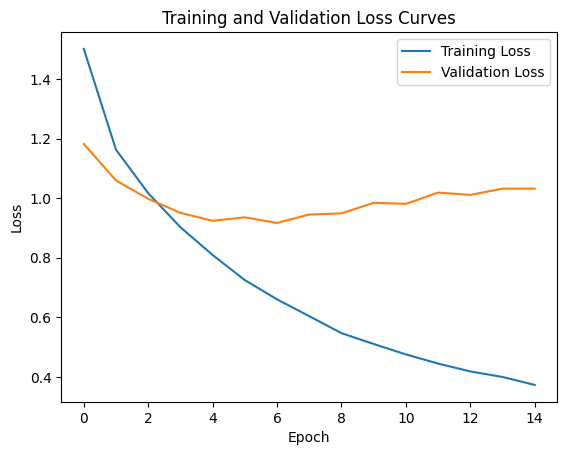

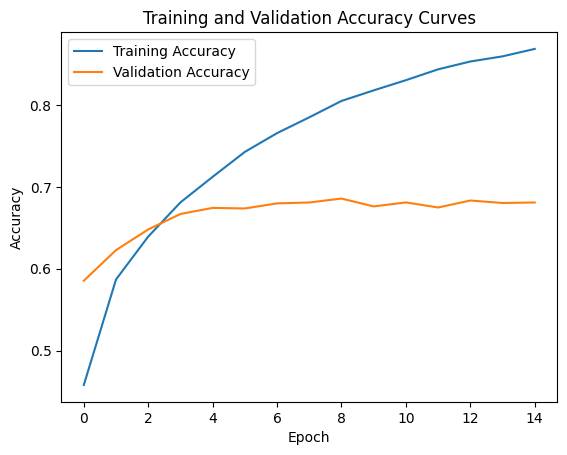

In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.show()